In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b7d5000591aa027ece47a9ccad5b0a15d8e207ea0d559ea25b33286a7ebdc574
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import sys
from sklearn.metrics import f1_score, accuracy_score

import lime
import lime.lime_tabular

In [4]:
df=pd.read_csv("/content/healthcare-dataset-stroke-data.csv.xls")
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
df.describe().T

count          mean           std    min        25%  \
id                 5110.0  36517.829354  21161.721625  67.00  17741.250   
age                5110.0     43.226614     22.612647   0.08     25.000   
hypertension       5110.0      0.097456      0.296607   0.00      0.000   
heart_disease      5110.0      0.054012      0.226063   0.00      0.000   
avg_glucose_level  5110.0    106.147677     45.283560  55.12     77.245   
bmi                4909.0     28.893237      7.854067  10.30     23.500   
stroke             5110.0      0.048728      0.215320   0.00      0.000   

                         50%       75%       max  
id                 36932.000  54682.00  72940.00  
age                   45.000     61.00     82.00  
hypertension           0.000      0.00      1.00  
heart_disease          0.000      0.00      1.00  
avg_glucose_level     91.885    114.09    271.74  
bmi                   28.100     33.10     97.60  
stroke                 0.000      0.00      1.00

In [6]:

df["bmi"].fillna(28.893237, inplace=True)

df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
X=df.iloc[:,:-1]
Y=df.iloc[:,-1]

In [9]:


gender=pd.get_dummies(X["gender"],drop_first=True)
ever_married=pd.get_dummies(X["ever_married"],drop_first=True)
work_type =pd.get_dummies(X["work_type"],drop_first=True)
Residence_type=pd.get_dummies(X["Residence_type"],drop_first=True)

smoking_status=pd.get_dummies(X["smoking_status"],drop_first=True)



print(gender)
print(ever_married)
print(work_type)
print(Residence_type)
print(smoking_status)

      Male  Other
0        1      0
1        0      0
2        1      0
3        0      0
4        0      0
...    ...    ...
5105     0      0
5106     0      0
5107     0      0
5108     1      0
5109     0      0

[5110 rows x 2 columns]
      Yes
0       1
1       1
2       1
3       1
4       1
...   ...
5105    1
5106    1
5107    1
5108    1
5109    1

[5110 rows x 1 columns]
      Never_worked  Private  Self-employed  children
0                0        1              0         0
1                0        0              1         0
2                0        1              0         0
3                0        1              0         0
4                0        0              1         0
...            ...      ...            ...       ...
5105             0        1              0         0
5106             0        0              1         0
5107             0        0              1         0
5108             0        1              0         0
5109             0        0    

In [10]:
X1=X.drop(["gender","ever_married","work_type","Residence_type","smoking_status"],axis=1)

In [11]:
X2=pd.concat([X1,gender,ever_married,work_type,Residence_type,smoking_status],axis=1)

In [12]:
print(X2)

         id   age  hypertension  heart_disease  avg_glucose_level        bmi  \
0      9046  67.0             0              1             228.69  36.600000   
1     51676  61.0             0              0             202.21  28.893237   
2     31112  80.0             0              1             105.92  32.500000   
3     60182  49.0             0              0             171.23  34.400000   
4      1665  79.0             1              0             174.12  24.000000   
...     ...   ...           ...            ...                ...        ...   
5105  18234  80.0             1              0              83.75  28.893237   
5106  44873  81.0             0              0             125.20  40.000000   
5107  19723  35.0             0              0              82.99  30.600000   
5108  37544  51.0             0              0             166.29  25.600000   
5109  44679  44.0             0              0              85.28  26.200000   

      Male  Other  Yes  Never_worked  P

In [13]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   avg_glucose_level  5110 non-null   float64
 5   bmi                5110 non-null   float64
 6   Male               5110 non-null   uint8  
 7   Other              5110 non-null   uint8  
 8   Yes                5110 non-null   uint8  
 9   Never_worked       5110 non-null   uint8  
 10  Private            5110 non-null   uint8  
 11  Self-employed      5110 non-null   uint8  
 12  children           5110 non-null   uint8  
 13  Urban              5110 non-null   uint8  
 14  formerly smoked    5110 non-null   uint8  
 15  never smoked       5110 non-null   uint8  
 16  smokes             5110 

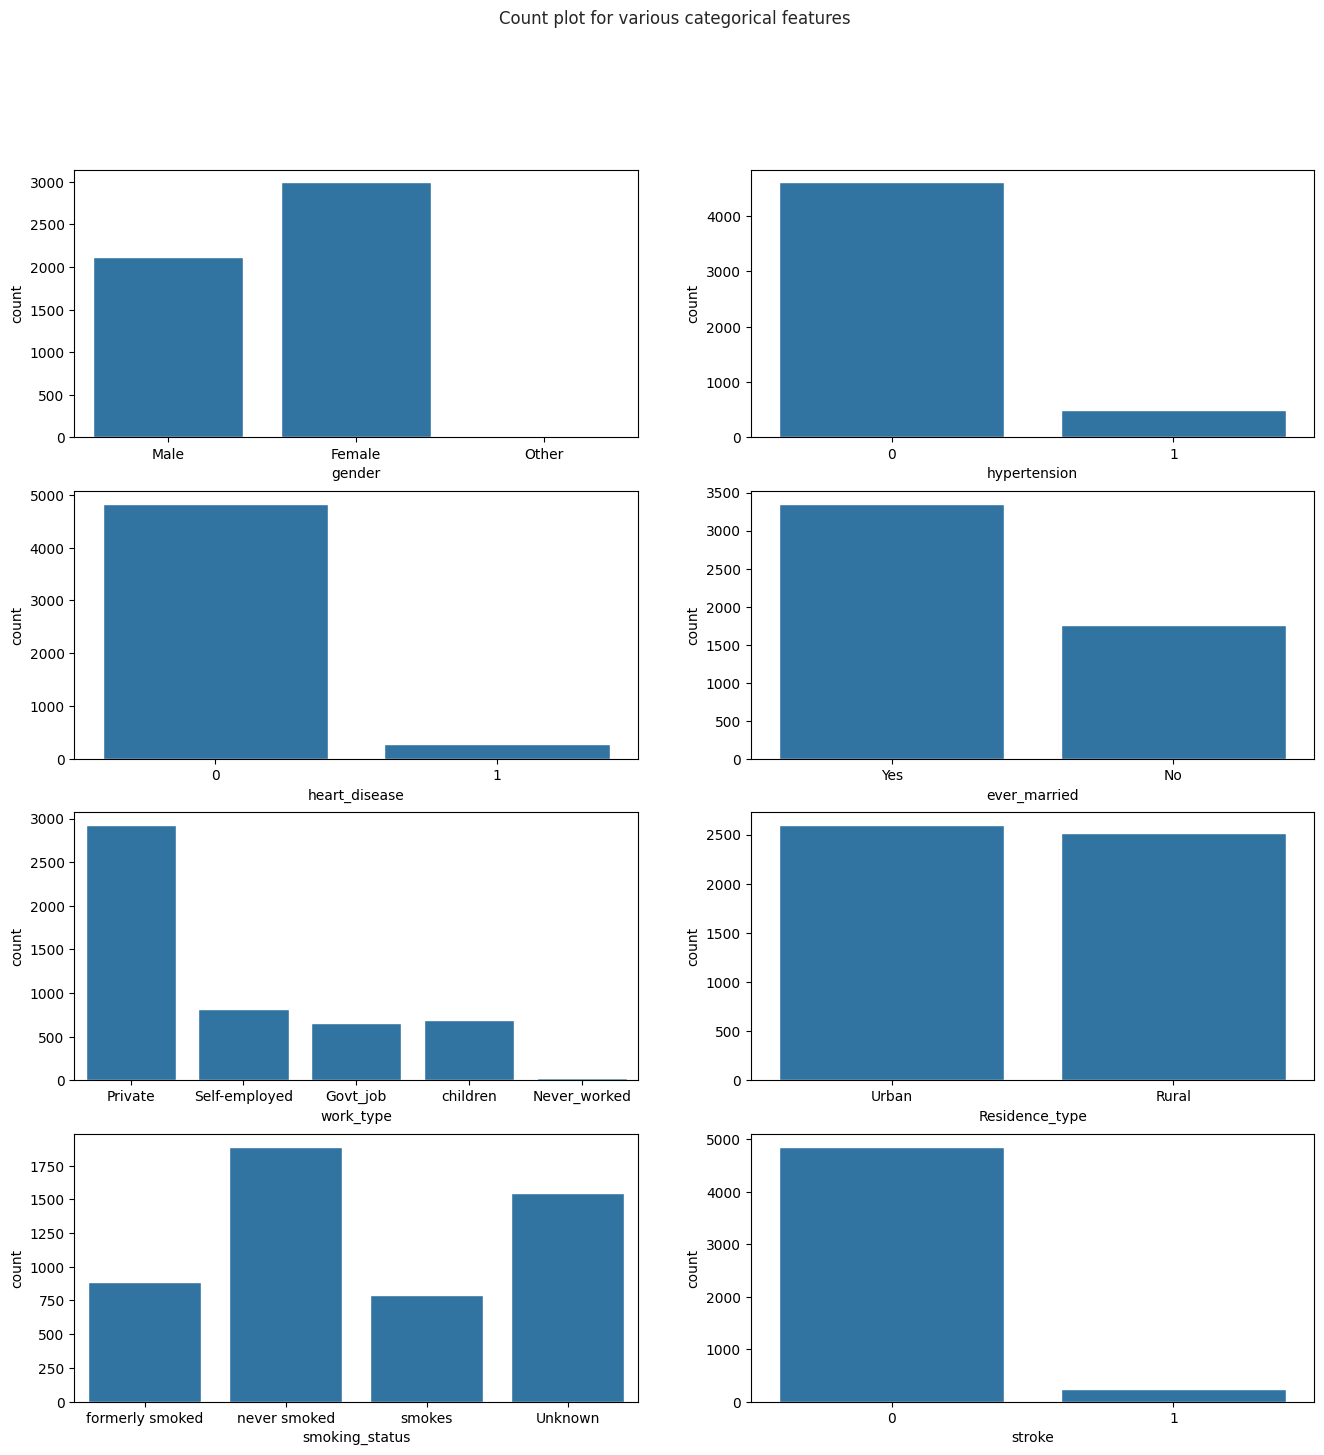

In [14]:
fig,axes = plt.subplots(4,2,figsize = (16,16))
sns.set_style('whitegrid')
fig.suptitle("Count plot for various categorical features")

sns.countplot(ax=axes[0,0],data=df,x='gender')
sns.countplot(ax=axes[0,1],data=df,x='hypertension')
sns.countplot(ax=axes[1,0],data=df,x='heart_disease')
sns.countplot(ax=axes[1,1],data=df,x='ever_married')
sns.countplot(ax=axes[2,0],data=df,x='work_type')
sns.countplot(ax=axes[2,1],data=df,x='Residence_type')
sns.countplot(ax=axes[3,0],data=df,x='smoking_status')
sns.countplot(ax=axes[3,1],data=df,x='stroke')

plt.show()

In [15]:
fig = px.box(data_frame = df,
            x = "avg_glucose_level",
            width = 800,
            height = 300)
fig.update_layout({"template":"plotly_dark"})
fig.show()

In [16]:

cont_cols = ["age","avg_glucose_level","bmi"]

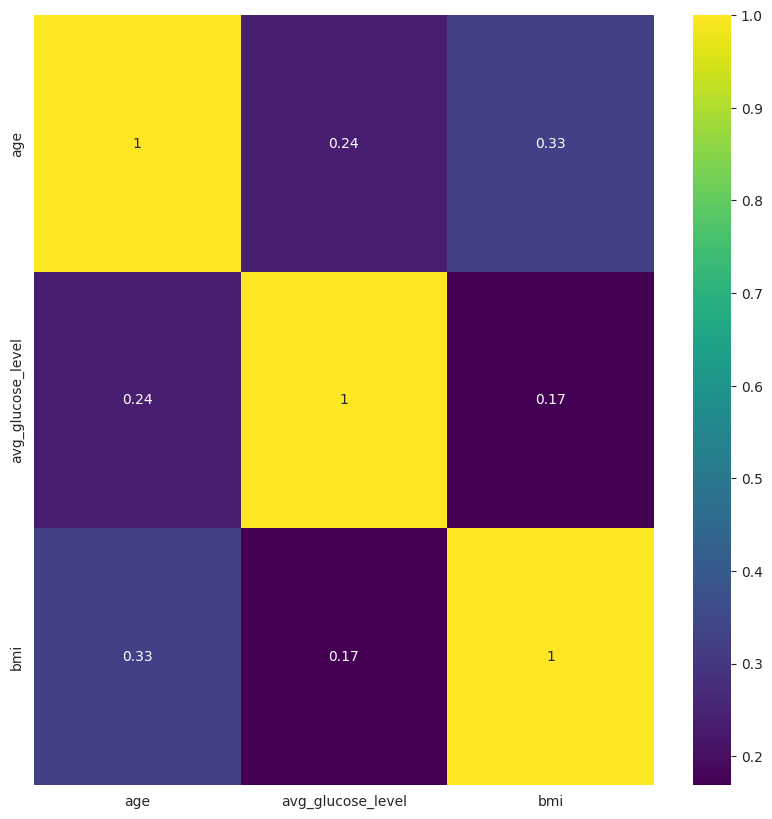

In [17]:
cr = df[cont_cols].corr()
plt.figure(figsize = (10,10))
sns.heatmap(cr,cmap="viridis", annot = True)
plt.show()

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X2,Y,test_size=0.2,random_state=11)

In [19]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_np = X_train.to_numpy()
y_np = Y_train.to_numpy()
x_np, y_np = oversample.fit_resample(x_np, y_np)
x_over = pd.DataFrame(x_np, columns=X_train.columns)
y_over = pd.Series(y_np, name=Y_train.name)
X_train=x_over
Y_train=y_over
print(X_train.shape)
print(X_test.shape)

(7788, 17)
(1022, 17)


In [20]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
Y_pred=rf.predict(X_test)

print(f"F1 Score {f1_score(Y_test, Y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(Y_test, Y_pred)}")

F1 Score 0.5004767513601436
Accuracy 0.9403131115459883


In [27]:
X2.query("avg_glucose_level>=200")[["id","avg_glucose_level"]]



id  avg_glucose_level
0      9046             228.69
1     51676             202.21
13     8213             219.84
14     5317             214.09
17    34120             221.29
...     ...                ...
5029  66951             206.49
5034  65405             253.86
5035  49773             203.36
5061  38009             223.78
5062  11184             211.58

[434 rows x 2 columns]

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                   verbose=True, mode='classification')


In [29]:
print(Y_test.values[23])
exp = explainer.explain_instance(X_test.iloc[23], rf.predict_proba,num_features=5)

0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Intercept 0.13779133298001198
Prediction_local [0.14732224]
Right: 0.1


In [30]:
exp.show_in_notebook(show_table=True)

So, the biased data in "avg_glucose_level" labelled feature is not effecting our model that much.

In [31]:
print(Y_test.values[29])
exp = explainer.explain_instance(X_test.iloc[29], rf.predict_proba)

0
Intercept 0.16581782135387288
Prediction_local [0.04396141]
Right: 0.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [32]:
exp.show_in_notebook(show_table=True)